# Exploration of dataset

### Install needed dependency

In [2]:
# %pip install pandas
# %pip install matplotlib
# %pip install numpy
# %pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions

In [27]:
def make_histogram(df: pd.DataFrame, variable: str, binwidth: int, lower_limit: int = None, upper_limit: int = None) -> None:
    if upper_limit is None:
        upper_limit = df[variable].max()

    if lower_limit is None:
        lower_limit = df[variable].min()

    bins = np.arange(lower_limit, upper_limit + binwidth, binwidth)

    plt.hist(df[variable], bins=bins, edgecolor='black',
             alpha=0.75, range=[df[variable].min(), upper_limit])

    plt.ylabel("Count")
    plt.xlabel(variable.title)


def make_scatter_plot(df: pd.DataFrame, para1: str, para2: str, logx: bool = False, logy: bool = False):
    plt.plot(df[para1], df[para2], '*', alpha=0.1)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale('log')
    plt.xlabel(para1)
    plt.ylabel(para2)


def corr_heatmap(df: pd.DataFrame, figsize=(10, 10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df.corr(), vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax


def min_max_normalize(data: pd.DataFrame) -> pd.DataFrame:
    normalize_df = (data - data.min()) / \
        (data.max() - data.min())
    return normalize_df


## Import dataset

I am also dropping passengerId, because its the same as rownumber / but not zero-indexed.

In [5]:
dataframe = pd.read_csv('Titanic.csv')
dataframe.drop('PassengerId', axis=1, inplace=True)


## Explore Data

In [6]:
dataframe.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
dataframe.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [9]:
dataframe["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [10]:
len(dataframe.Ticket.unique())

681

In [11]:
dataframe.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [12]:
dataframe.groupby("Sex").describe()

Survived                                              Pclass            \
          count      mean       std  min  25%  50%  75%  max  count      mean   
Sex                                                                             
female    314.0  0.742038  0.438211  0.0  0.0  1.0  1.0  1.0  314.0  2.159236   
male      577.0  0.188908  0.391775  0.0  0.0  0.0  0.0  1.0  577.0  2.389948   

        ... Parch        Fare                                               \
        ...   75%  max  count       mean        std   min        25%   50%   
Sex     ...                                                                  
female  ...   1.0  6.0  314.0  44.479818  57.997698  6.75  12.071875  23.0   
male    ...   0.0  5.0  577.0  25.523893  43.138263  0.00   7.895800  10.5   

                         
          75%       max  
Sex                      
female  55.00  512.3292  
male    26.55  512.3292  

[2 rows x 48 columns]

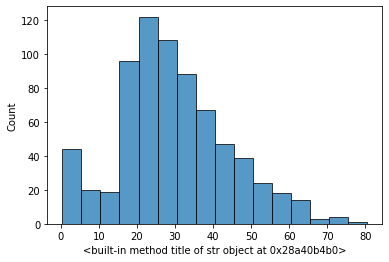

In [39]:
make_histogram(dataframe, variable='Age', binwidth=5)

In [ ]:
dataframe.groupby('Survived').describe()

Pclass                                                 Age  \
          count      mean       std  min  25%  50%  75%  max  count   
Survived                                                              
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0  424.0   
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0  290.0   

                     ... Parch        Fare                             \
               mean  ...   75%  max  count       mean        std  min   
Survived             ...                                                
0         30.626179  ...   0.0  6.0  549.0  22.117887  31.388207  0.0   
1         28.343690  ...   1.0  5.0  342.0  48.395408  66.596998  0.0   

                                         
              25%   50%   75%       max  
Survived                                 
0          7.8542  10.5  26.0  263.0000  
1         12.4750  26.0  57.0  512.3292  

[2 rows x 40 columns]

In [ ]:
dataframe.groupby('Embarked').describe()

Survived                                              Pclass  \
            count      mean       std  min  25%  50%  75%  max  count   
Embarked                                                                
C           168.0  0.553571  0.498608  0.0  0.0  1.0  1.0  1.0  168.0   
Q            77.0  0.389610  0.490860  0.0  0.0  0.0  1.0  1.0   77.0   
S           644.0  0.336957  0.473037  0.0  0.0  0.0  1.0  1.0  644.0   

                    ... Parch        Fare                                \
              mean  ...   75%  max  count       mean        std     min   
Embarked            ...                                                   
C         1.886905  ...   1.0  3.0  168.0  59.954144  83.912994  4.0125   
Q         2.909091  ...   0.0  5.0   77.0  13.276030  14.188047  6.7500   
S         2.350932  ...   0.0  6.0  644.0  27.079812  35.887993  0.0000   

                                                
               25%    50%        75%       max  
Embarked                                        
C         13.69795  29.70  78.500025  512.3292  
Q          7.75000   7.75  15.500000   90.0000  
S          8.05000  13.00  27.900000  263.0000  

[3 rows x 48 columns]

In [ ]:
dataframe['Ticket'].duplicated().sum()

210

In [ ]:
dataframe.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
dataframe.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
dataframe[dataframe['Age'] < 3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
16,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q
78,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
119,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.00,4,2,347082,31.2750,NaN,S
164,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,NaN,S
172,1,3,"Johnson, Miss. Eleanor Ileen",female,1.00,1,1,347742,11.1333,NaN,S
183,1,2,"Becker, Master. Richard F",male,1.00,2,1,230136,39.0000,F4,S
205,0,3,"Strom, Miss. Telma Matilda",female,2.00,0,1,347054,10.4625,G6,S
297,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
305,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S


In [ ]:
dataframe['Name'].sort_index()

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

# Some preprocessing
First of all, I'm going to make a new dataframe from the original, because I don't really need to analyze the PassengerId, since it is the same as index, just its not 0'indexed.
Meaning, row 1 = 0 in index, and 1 as Id.
I'm also going to remove the Name from the dataframe, when it does not really have any impact on my analysis, all the information I need regarding how old they are, sex is already provided in the dataset.

I know for the next steps. That I can exclude Passenger and Name.